

[![Abrir In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/franguerrero/TFM_SegmentacionImagenesMedicas/blob/main/cuadernos_jupyter/TFM_EntrenamientoFIno_DesdeModeloPreentrenado.ipynb)


# Modelo Pre-Entrenado de Swin UNETR 

Utilizamos pesos de preentrenamiento auto-supervisado del codificador Swin UNETR (Transformador Swin 3D) en una cohorte de 5050 escaneos de TC de conjuntos de datos disponibles públicamente. El codificador se preentrena usando tareas previas de reconstrucción, predicción de rotación y aprendizaje contrastivo como se muestra a continuación. 

![image](https://lh3.googleusercontent.com/pw/AM-JKLVLgduGZ9naCSasWg09U665NBdd3UD4eLTy15wJiwbmKLS_p5WSZ2MBcRePEJO2tv9X3TkC52MsbnomuPy5JT3vSVeCji1MOEuAzcsxily88TdbHuAt6PzccefwKupbXyOCumK5hzz5Ul38kZnlEQ84=w397-h410-no?authuser=2)

 

## Setup del entorno

Verificamos si está conectado con la GPU y mostramos la información de la GPU

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Feb  4 15:46:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    55W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Instalamos las librerias de MONAI en su ultima versión estable que en el momento de la realización de este cuaderno es la 1.1.0

!pip install -q "monai[nibabel, tqdm, einops]"==1.1.0
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.5 MB/s eta 0:00:00


In [3]:
# Importamos aquellas librerias que nos van a hacer falta tanto de MONAI como otras como de numpy o matplotlib
# Finalizamos viendo las versiones instaladas de cada una de ellas

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)


import torch

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.14.1+cu116
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup directorios de trabajo

Establecemos la conexión con la cuenta de Google Drive y le especificamos la carpeta donde vamos a almacenar los resultados del modelo que obtengamos

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
os.environ['MONAI_DATA_DIRECTORY'] = '/content/gdrive/MyDrive/TFM_SegmentacionImagenesMedicas/Resultados/'

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/content/gdrive/MyDrive/TFM_SegmentacionImagenesMedicas/Resultados/


## Setup de las transformaciones para entrenamiento (training) y validacion


In [7]:
num_samples = 4

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)

 ## Descarga del dataset y almacenamiento en Google Drive
El dataset ha sido descargado de  https://www.synapse.org/#!Synapse:syn3193805/wiki/217752 y se ha subido a la aplicacion de google drive. 

En concreto a la ruta \MyDrive\TFM_SegmentacionImagenesMedicas\Datasets\BTCV 

Es importante señalar que las imágenes del dataset de BTCV van a la carpeta \textbackslash imagesTr y las etiquetas van a la carpeta \textbackslash labelsTr.

Además también se encuentra el fichero dataset\_0.json que contiene la descripción de las imágenes y sus correspondientes etiquetas de ground truth que van a ser usadas para el entrenamiento y las que van a ser usadas para validación. En nuestro caso se han usado 24 imágenes (y correspondientes etiquetas) para entrenamiento y 6 para validación. Las de validación se corresponden con la numeración desde la 35 a la 40 ambas incluidas.

In [8]:
#data_dir = "data/"
#split_json = "dataset_0.json"

# Establecemos la ruta donde se encuentran las imagenes y etiquetas de BTCV descargadas
data_dir = "/content/gdrive/MyDrive/TFM_SegmentacionImagenesMedicas/Datasets/BTCV/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")

# Cacheamos los datos de entrenamiento y validación
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


## Visualizamos imagen y etiquetas y comprobamos la forma de los datos

forma de la imagen: torch.Size([1, 254, 210, 292]), forma de la etiqueta: torch.Size([1, 254, 210, 292])


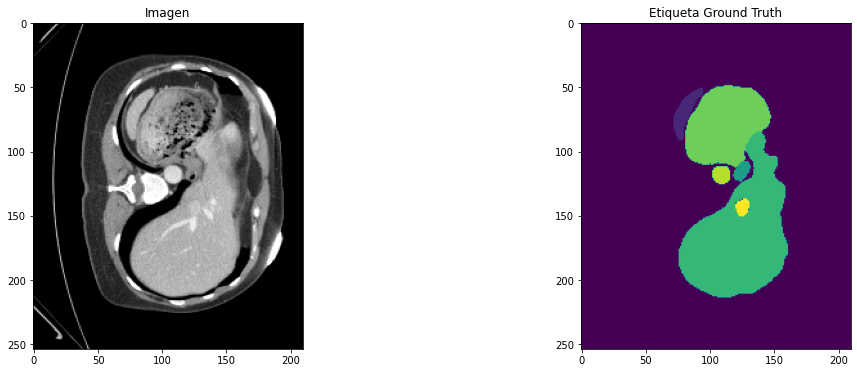

In [9]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
# Seleccionamos uno cualquiera, por ejemplo el que esta en el lugar 0 del map
case_num = 4
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"forma de la imagen: {img_shape}, forma de la etiqueta: {label_shape}")
plt.figure("Imagen", (18, 6))
plt.subplot(1, 2, 1)
plt.title("Imagen")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Etiqueta Ground Truth")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Creación del modelo Swin UNETR 

En esta sección, creamos un modelo Swin UNETR para la segmentación multi-órgano de 14 clases. Usamos un tamaño de característica de 48, que es compatible con los pesos preentrenados auto-supervisados. También usamos el puntos de control de gradiente (use_checkpoint) para un entrenamiento más eficiente en memoria.

In [10]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=14,
    feature_size=48,
    use_checkpoint=True,
).to(device)

### Inicializar el codificador Swin UNETR desde pesos preentrenados auto-supervisados

En esta sección, inicializamos el codificador Swin UNETR desde los pesos preentrenados. Los pesos se pueden descargar usando el comando wget a continuación..

In [11]:
# !wget https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt

In [12]:
# Cargamos los pesos del preentrenado Swin-UNETR
weight = torch.load(os.path.join(root_dir, "model_swinvit.pt"))
model.load_from(weights=weight)
print("Usando pesos del backbone Swin UNETR preentrenados auto-supervisados")

Usando pesos del backbone Swin UNETR preentrenados auto-supervisados


### Funcion de pérdida y el optimizador

In [13]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

### Ejecutamos un proceso de entrenamiento de red neuronal típico de PyTorch

In [14]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validar (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (Perdida loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (Perdida loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validar (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_usandopreentrenado.pth"))
                print(
                    "Se ha salvado el modelo ! Mejor Avg. Dice: {} Actual Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "No se ha salvado el modelo ! Mejor Avg. Dice: {} Actual Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [15]:
max_iterations = 2000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_usandopreentrenado.pth")))

Training (22 / 2000 Steps) (Perdida loss=2.37737): 100%|██████████| 23/23 [00:26<00:00,  1.15s/it]
Training (45 / 2000 Steps) (Perdida loss=2.18570): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (68 / 2000 Steps) (Perdida loss=2.21077): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (91 / 2000 Steps) (Perdida loss=1.96703): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (114 / 2000 Steps) (Perdida loss=1.92017): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (137 / 2000 Steps) (Perdida loss=1.95250): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (160 / 2000 Steps) (Perdida loss=1.78454): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (183 / 2000 Steps) (Perdida loss=1.64440): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (206 / 2000 Steps) (Perdida loss=1.58732): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (229 / 2000 Steps) (Perdida loss=1.72075): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Trai

Se ha salvado el modelo ! Mejor Avg. Dice: 0.1361090987920761 Actual Avg. Dice: 0.1361090987920761


Training (505 / 2000 Steps) (Perdida loss=1.31873): 100%|██████████| 23/23 [00:19<00:00,  1.17it/s]
Training (528 / 2000 Steps) (Perdida loss=1.63544): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (551 / 2000 Steps) (Perdida loss=1.18931): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (574 / 2000 Steps) (Perdida loss=1.30984): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (597 / 2000 Steps) (Perdida loss=1.41016): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (620 / 2000 Steps) (Perdida loss=1.34507): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (643 / 2000 Steps) (Perdida loss=1.43927): 100%|██████████| 23/23 [00:10<00:00,  2.25it/s]
Training (666 / 2000 Steps) (Perdida loss=1.13519): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (689 / 2000 Steps) (Perdida loss=1.18793): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (712 / 2000 Steps) (Perdida loss=1.21701): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]


Se ha salvado el modelo ! Mejor Avg. Dice: 0.2881496548652649 Actual Avg. Dice: 0.2881496548652649


Training (1011 / 2000 Steps) (Perdida loss=1.24619): 100%|██████████| 23/23 [00:18<00:00,  1.25it/s]
Training (1034 / 2000 Steps) (Perdida loss=1.23872): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (1057 / 2000 Steps) (Perdida loss=1.17506): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (1080 / 2000 Steps) (Perdida loss=1.17531): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (1103 / 2000 Steps) (Perdida loss=1.23324): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (1126 / 2000 Steps) (Perdida loss=1.02190): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (1149 / 2000 Steps) (Perdida loss=1.07687): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (1172 / 2000 Steps) (Perdida loss=1.07965): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (1195 / 2000 Steps) (Perdida loss=1.06464): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (1218 / 2000 Steps) (Perdida loss=1.24926): 100%|██████████| 23/23 [00:10<00:00,  

Se ha salvado el modelo ! Mejor Avg. Dice: 0.47442322969436646 Actual Avg. Dice: 0.47442322969436646


Training (1517 / 2000 Steps) (Perdida loss=1.01888): 100%|██████████| 23/23 [00:18<00:00,  1.25it/s]
Training (1540 / 2000 Steps) (Perdida loss=0.96344): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (1563 / 2000 Steps) (Perdida loss=0.95963): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (1586 / 2000 Steps) (Perdida loss=0.98843): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (1609 / 2000 Steps) (Perdida loss=0.98601): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (1632 / 2000 Steps) (Perdida loss=1.11194): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (1655 / 2000 Steps) (Perdida loss=1.03947): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (1678 / 2000 Steps) (Perdida loss=1.02445): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (1701 / 2000 Steps) (Perdida loss=1.18914): 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
Training (1724 / 2000 Steps) (Perdida loss=0.94433): 100%|██████████| 23/23 [00:10<00:00,  

Se ha salvado el modelo ! Mejor Avg. Dice: 0.5574969053268433 Actual Avg. Dice: 0.5574969053268433


<All keys matched successfully>

In [16]:
print(f"entrenamiento completado, mejor metrica conseguida: {dice_val_best:.4f} " f" en la iteracion: {global_step_best}")

entrenamiento completado, mejor metrica conseguida: 0.5575  en la iteracion: 2000


### Dibujamos las gráficas de la funcion de pérdidas y de la métrica DICE que vamos obteniendo en las iteraciones

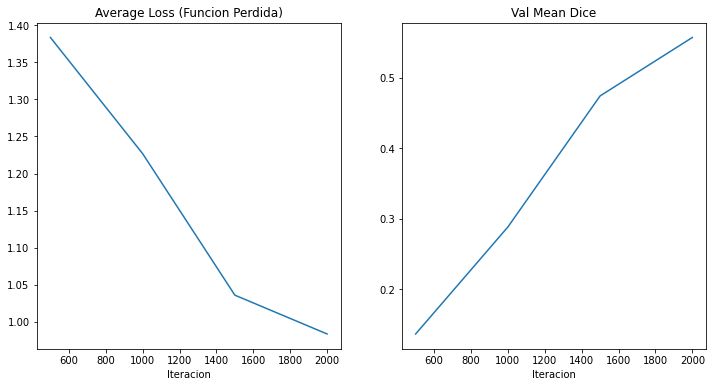

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Average Loss (Funcion Perdida)")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteracion")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteracion")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

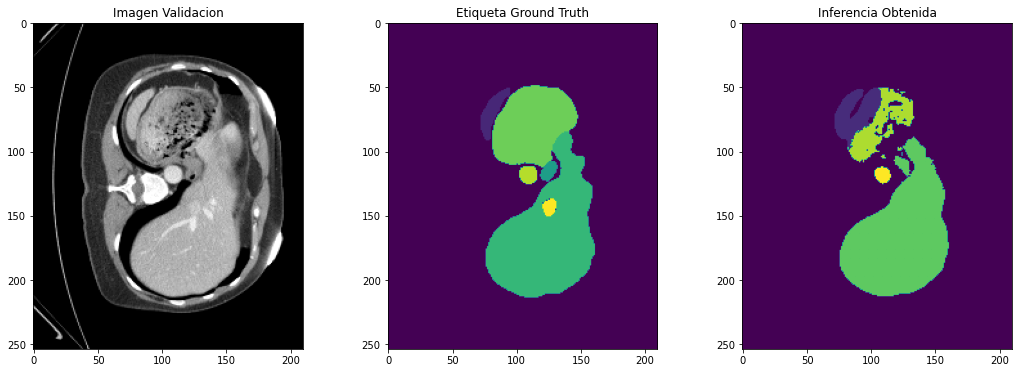

In [18]:
case_num = 4
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_usandopreentrenado.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("Imagen Validacion")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("Etiqueta Ground Truth")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("Inferencia Obtenida")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()